## Get the Import

In [274]:
import os
import pandas as pd
import numpy as np
import gensim.models.word2vec as w2v
from gensim.corpora.textcorpus import TextCorpus
import re
from datetime import datetime
import _pickle as pickle
from scipy.sparse import *
import matplotlib.pyplot as plt

## Preprocessing the Data

In [3]:
def get_chunks(file_size):
    chunk_start = 0
    chunk_size = 0x20000
    while chunk_start + chunk_size < file_size:
        yield(chunk_start, chunk_size)
        chunk_start += chunk_size
    final_chunk_size = file_size - chunk_start
    yield(chunk_start, final_chunk_size)

def read_file_chunked(file_path):
    with open(file_path,encoding='utf-8') as file_:
        file_size = os.path.getsize(file_path)
        print(file_size)
        print('File size: {}'.format(file_size))
        progress = 0

        for chunk_start, chunk_size in get_chunks(file_size):

            file_chunk = file_.read(chunk_size)
#             print((file_chunk))
            f.write(file_chunk)
            progress += len(file_chunk)
            if(progress>=file_size/2):
                break
#             print('{0} of {1} bytes read'.format(progress, file_size))
#             print('In Progress...')
        print('Completed')

f = open('prep.tsv', 'a+', encoding='utf-8')
read_file_chunked('./imput/dataset.tsv')

2529193595
File size: 2529193595
Completed


## Extracting the relevant columns (User_id, Timestamp, Song_name)

In [4]:
f = open('prep.tsv',encoding='utf-8')
f1 = open('newprep.tsv','w',encoding='utf-8')
for x in range(4781164):
    s = f.readline()
    l = s.split('\t')
    f1.write(l[0][5:]+'\t'+l[1]+'\t'+l[-1])
f.close()
f1.close() 

### Converting timestamp into standard format (YYYYMMDDHHMMSS)

In [5]:
def timestamp(time):
    arr=re.split('-|T|Z|:',time)
    date_time = arr[0]+arr[1]+arr[2]+arr[3]+arr[4]+arr[5]
    return date_time

### Creating Music Play sequence dictionary (MPS). Only keeping songs which have been played within 800 secs and have been played for at least 10 times

In [6]:
columns=['UserID', 'TimeStamp', 'Song'] 
data = pd.read_csv('newprep.tsv',delimiter='\t',encoding='utf-8', names=columns,header=None)
data.head()
print(len(data))


data.sort_values(by=['UserID','TimeStamp'],ascending=[True,True],inplace=True)
MPS = {}
idnum = data.iloc[0]['UserID']
song = data.iloc[0]['Song']
ts = data.iloc[0]['TimeStamp']
l = [song]
for i in range(1,len(data)):
#     print(i)
    newid = data.iloc[i]['UserID']
    tsnew = data.iloc[i]['TimeStamp']
#     print(tsnew)
    newsong = data.iloc[i]['Song']
    if newid == idnum:
        ts1 = timestamp(data.iloc[i]['TimeStamp'])
        ts2 = timestamp(data.iloc[i-1]['TimeStamp'])
        d = pd.Timedelta(datetime.strptime(ts1, '%Y%m%d%H%M%S') - datetime.strptime(ts2, '%Y%m%d%H%M%S')).seconds
        if d < 800:
            l.append(data.iloc[i]['Song'])
        else:
            if idnum in MPS.keys():
                MPS[idnum].append(l)
            else:
                MPS[idnum] = [l]
            l = []
            l.append(data.iloc[i]['Song'])
    else:
        if idnum in MPS.keys():
            MPS[idnum].append(l)
        else:
            MPS[idnum] = [l]
        idnum = newid
        l = []
        l.append(data.iloc[i]['Song'])
if l not in MPS[idnum]:
    if idnum in MPS.keys():
        MPS[idnum].append(l)
    else:
        MPS[idnum] = [l]
for user in MPS:
    for ele in MPS[user]:
        if len(ele) < 10:
            MPS[user].remove(ele)

4752899


### Save the Music Play Sequence (MPS) in a file

In [7]:
#Write the MPS
pickle_out = open("MPS.pickle","wb")
pickle.dump(MPS, pickle_out)
pickle_out.close()

### Read the Music PLay Sequence (MPS) from the file

In [270]:
# Read the MPS
pickle_in = open("./MPS.pickle","rb")
MPS = pickle.load(pickle_in)

### Generating the corpus. Corpus is the final collection of all the Music Play sequene which satisfy the above mentioned criterion. The corpus is a list of list wherein every list is an individual play sequence

In [ ]:
corpus = []
for i in range(len(MPS)):
    l = MPS[i+1]
#     print(len(l))
    for j in range(len(l)):
        if len(l[j]) > 10:
            corpus.append(l[j])
print("Length of corpus:",len(corpus))

### Assigning the Songs individual identification for indexing. Building the vocabulary

In [10]:
#refine string
song2vec = w2v.Word2Vec(sg=1,seed=1,size=100,min_count=10,window=5)
song2vec.build_vocab(corpus)

# Preprocess the songs that contain unprintable unicode characters
vocabulary1=list(song2vec.wv.vocab)
print(len(vocabulary1))
vocabulary1=list(song2vec.wv.vocab)
vocabulary=[]
for word in vocabulary1:
    if re.match('[A-Za-z0-9\'\?\&\)\(\+\!\-\*\.\, ]+$',word):
        vocabulary.append(word)

vocabulary.sort()

77168
['! (Foreword)', '& Down', '& Down (Siriusmo Vs. Boys Noize Mix)', "''Bang Bang (My Baby Shot Me Down)'' By Nancy Sinatra", "''Green Hornet'' By Al Hirt", "''Ode To Oren Ishii'' By The Rza", "''Run Fay Run'' By Isaac Hayes", "''That Certain Female'' By Charlie Feathers", "''The Grand Duel (Parte Prima)'' By Luis Bacalov", "''Woo Hoo'' By The 5.6.7.8'S", "'03 Til Infinite", "'39", "'52 Ford", "'64 Aka Go", "'68 Aka Only Time", "'74-'75", "'75 Aka Stay With You", "'76 Aka The Slow Train", "'79 Aka The Shouty Track", "'84 Pontiac Dream", "'88 Aka Come Down On Me", "'90 Aka A Man Like Me", "'93 Aka Don'T Stop Now", "'95 Aka Make Things Right", "'97 Bonnie & Clyde", "'98 Freestyle", "'A' Bomb In Wardour Street", "'Cause I Love You", "'Cello Song", "'Cross The Breeze", "'Cuz I Can", "'Dimitri'", "'Dozer Rage", "'Hm", "'Merican", "'Reck A Nowhere", "'Round Midnight", "'Ruku'S Room' From Satyajit Ray'S Film Joi Baba Felunath", "'S Wonderful", "'S'Wonderful", "'They' Schools", "'Til Days 

### Saving the Song2vec model

In [12]:
song2vec.save("song2vec.model")
song2vec.train(corpus,total_examples=len(corpus),epochs=10)

(31229520, 39464000)

### Get song Recommendation based on the Song2vec Model

In [224]:
# To find top n songs for any song, just put the name in song name
def get_song(name): 
    song_name = name
    l = song2vec.most_similar(song_name,topn=6)
    print ("Top 6 Songs for:",name,"\n")
    print ("Name\t\t\t","Similarity Score\n")
    for ele in l:
        name,sim = ele[0],ele[1]
        print (name[0:10],"\t\t",sim)

### The following cell show the list of song recommended for the input and it's similarity value with the recommended songs

In [227]:
get_song("The Fox")

Top 6 Songs for: The Fox 

Name			 Similarity Score

Start Toge 		 0.8167651891708374
Milkshake  		 0.7961223125457764
Let'S Call 		 0.795258641242981
Leave You  		 0.7926040291786194
The End Of 		 0.7861700057983398
One Song F 		 0.7859086394309998


/home/shad3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


In [271]:
get_song("The Fear")

/home/shad3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Top 6 Songs for: The Fear 

Name			 Similarity Score

Kabul Shit 		 0.673518180847168
Big Bills 		 0.6527096033096313
Fag Hag 		 0.6492824554443359
Fui 		 0.6409088373184204
Change (Fe 		 0.6358767747879028
Nothing Ev 		 0.6276048421859741


In [272]:
get_song("The Ghost Of Genova Heights")

Top 6 Songs for: The Ghost Of Genova Heights 

Name			 Similarity Score

Midnight C 		 0.9018418192863464
Window Bir 		 0.9011083841323853
Life 2: Th 		 0.8958629965782166
Today Will 		 0.8914932608604431
Bitches In 		 0.8491013646125793
The Beginn 		 0.8459848165512085


/home/shad3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


### Getting Rating from the Play sequence. The rating for a given user for a song has not been explicity specified there the play count has been been used to generate the rating

In [228]:
#get rating
colnames=['user_id', 'date', 'song']
df = pd.read_csv("newprep.tsv",names=colnames,header=None,delimiter="\t",error_bad_lines=False)

#add a song_id column
df["song_id"] = 0
#remove songs not in the vocabulary
df_new = df[df['song'].isin(vocabulary)]
df_new = df_new.sort_values(by=['song'])
df_2 = df_new.drop(columns=['date'])

#assign each song same ids as the one in mentioned 
df_2['song_id'] = df_2.song.astype('category').cat.codes
df_2 = df_2.groupby(['user_id', 'song_id']).size().reset_index(name='counts')
df_2['total'] = df_2['user_id'].map(df_2['user_id'].value_counts())

#generate the rating
df_2['rating'] = np.round(5*np.log(df_2['total']/(df_2 ['total'] - df_2['counts']) + 1))
df_2.head()

/home/shad3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


,user_id,song_id,counts,total,rating
0,1,19,14,1199,3.0
1,1,87,1,1199,3.0
2,1,93,1,1199,3.0
3,1,135,13,1199,3.0
4,1,155,1,1199,3.0


### Create the R matrix (Where rows are the users and the columns are the songs). Here each Rij value represents the rating given by the user to that particular song

In [231]:
## convert to CSR format
# read the already saved file
temp = pd.read_csv("out_2.csv",delimiter=",",error_bad_lines=False)
row = np.array(temp.iloc[:,1])
col = np.array(temp.iloc[:,2])
val = np.array(temp.iloc[:,-1])

row_size = len(temp.iloc[:,1].unique())
col_size = len(temp.iloc[:,2].unique())
rating_csr = csr_matrix( (val,(row,col)), shape=(row_size,col_size))

M = np.array(rating_csr.toarray(),dtype=float)
M = np.nan_to_num(M)
mask = np.zeros((M.shape[0],M.shape[1]))
mask = np.where(M != 0,1,0)

## Split data into training and testing

In [232]:
test_row = []
test_col = []
for i in range(800000):
    a = np.random.randint(0,row.shape[0]-1)
#     print (M[row[a],col[a]])
    test_row.append(row[a])
    test_col.append(col[a])
test_row = np.array(test_row)
test_col = np.array(test_col)

#get training and testing mask
train_mask = mask.copy()
train_mask[test_row,test_col] = 0
test_mask = mask - train_mask

# Calculate Error

In [245]:
def get_error_MF(M,P,Q,b):
    prediction = np.matmul(P,Q.T)
    error = np.sqrt(np.mean((M - test_mask*np.matmul(P,Q.T))**2))+b
    return error

## Perform Linear Regression

In [243]:
def linear_regression(M,train_mask,test_mask):
    alpha = 0.001
    K = [8,16,32,64]
    pb = 0.13
    qb = 0.1
    b = 1.1
    final_error = []
    
    for l in range(4):
        P = np.ones((M.shape[0],K[l]))
        Q = np.ones((M.shape[1],K[l]))
        print ("Error of K:",K[l])
        for k in range(5):
            for i in range(M.shape[0]):
                for j in range(M.shape[1]):

                    if (M[i][j]*train_mask[i,j] == 0):
                        continue

                    err = M[i][j] - np.matmul(P[i,:],Q[j,:].T)
                    p_ = P[i,:] + 2*alpha*err*Q[j,:]
                    q_ = Q[j,:] + 2*alpha*err*P[i,:]

                    P[i,:] = p_
                    Q[j,:] = q_
        error = get_error(M,P,Q,b)
        final_error.append(np.sqrt(np.mean((M - test_mask*np.matmul(P,Q.T))**2)))
        print ("Error for K[l]:",final_error[-1])

    return P,Q,final_error

In [246]:
p,q,simple_error = linear_regression(M,train_mask,test_mask)

Error for 8: 1.61
Error for 16: 1.58
Error for 32: 1.52
Error for 64: 1.48


### Biased MF Class

In [248]:
def linear_regression_biased(M,train_mask,test_mask):
    alpha = 0.00001
    beta = 0.1
    K = [8,16,32,64,128]
    b = 0.9
    final_error = []
    for l in range(4):
        P = np.ones((M.shape[0],K[l]))
        Q = np.ones((M.shape[1],K[l]))
        pb = np.zeros(M.shape[0])
        qb = np.zeros(M.shape[1])
        u = np.mean(M[np.where(M != 0)])
        print ("Error of K:",K[l])
        for k in range(5):
            for i in range(M.shape[0]):
                for j in range(M.shape[1]):

                    if (M[i][j]*train_mask[i,j] == 0):
                        continue

                    err = M[i][j] - u - np.matmul(P[i,:],Q[j,:].T) - pb[i] - qb[j]
                    p_ = P[i,:] + alpha*(2*err*Q[j,:] - beta*(P[i,:]*P[i,:]*P[i,:] ))
                    q_ = Q[j,:] + alpha*(2*err*P[i,:] - beta*(Q[j,:]*Q[j,:]*Q[j,:]))
                    pb[i] = pb[i] + alpha*((2*err) - beta*(pb[i]**2))
                    qb[j] = qb[j] + alpha*((2*err) - beta*(qb[j]**2))

                    P[i,:] = p_
                    Q[j,:] = q_
        error = get_error(M,P,Q,b)
        print ("Error for K[l]:",final_error[-1])
            
    
    return P,Q,final_error

In [249]:
p,q,biased_error = linear_regression_biased(M,train_mask,test_mask)

Error for 8: 1.59
Error for 16: 1.56
Error for 32: 1.49
Error for 64: 1.46


# Combining both Biased MF alongwith the Song2vec

In [266]:
def linear_regression_song2vec(M,train_mask,test_mask):
    alpha = 0.00001
    beta = 0.1
    K = [8,16,32,64,128]
    b = 0.8
    u = np.mean(M[np.where(M != 0)])
    final_error = []
    for l in range(4):
        P = np.ones((M.shape[0],K[l]))
        Q = np.ones((M.shape[1],K[l]))
        pb = np.zeros(M.shape[0])
        qb = np.zeros(M.shape[1])
        print ("Error of K:",K[l])
        for k in range(5):
            for i in range(M.shape[0]):
                for j in range(M.shape[1]):

                    if (M[i][j]*train_mask[i,j] == 0):
                        continue
                    
                    
                    try:
                        top5 = song2vec.most_similar(song_name,topn=5)
                    except:
                        continue
                        
                    
                    err = M[i][j] - u - np.matmul(P[i,:],Q[j,:].T) - pb[i] - qb[j]
                    p_ = P[i,:] + alpha*(2*err*Q[j,:] - beta*(P[i,:]*P[i,:]*P[i,:] ))
                    q_ = Q[j,:] + alpha*(2*err*P[i,:] - beta*(Q[j,:]*Q[j,:]*Q[j,:]))
                    pb[i] = pb[i] + alpha*((2*err) - beta*(pb[i]**2))
                    qb[j] = qb[j] + alpha*((2*err) - beta*(qb[j]**2))

                    P[i,:] = p_
                    Q[j,:] = q_
                    
                    song_name = vocabulary[j]
                    sub = 0
                    for v in range(5):
                        t1 = top5[v][1]
                        Qj = Q[vocabulary.index(top5[v][0]),:]
                        t2 = np.matmul(Q[j,:].T,Qj)
                        t3 = (t1-t2)*Qj + 0.1 * Qj
                        sub += t3
                    delQi = err - sub
                    Qi = Q[i,:]
                    Qi = Qi - alpha * (delQi)
                    Q[i,:] = Qi
        final_error.append(np.sqrt(np.mean((M - test_mask*np.matmul(P,Q.T))**2)))
        print ("Error for K[l]:",final_error[-1])
            
    
    return P,Q,pb,qb,final_error

In [268]:
temp = pd.read_csv("out_2.csv",delimiter=",",error_bad_lines=False)
temp = temp.loc[df['song'].isin(vocabulary)]
row = np.array(temp.iloc[:,1])
col = np.array(temp.iloc[:,2])
val = np.array(temp.iloc[:,-1])

row_size = len(temp.iloc[:,1].unique())
col_size = len(temp.iloc[:,2].unique())
rating_csr = csr_matrix( (val,(row,col)), shape=(row_size,col_size))

M = np.array(rating_csr.toarray(),dtype=float)
M = np.nan_to_num(M)
mask = np.zeros((M.shape[0],M.shape[1]))
mask = np.where(M != 0,1,0)
p,q,r,s,final_error = linear_regression_song2vec(M,train_mask,test_mask)


Error for 8: 1.51
Error for 8: 1.49
Error for 8: 1.41
Error for 8: 1.38


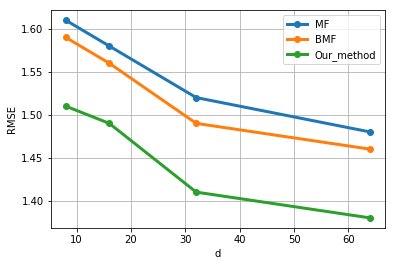

In [275]:
plt.plot(d, simple_error, label = 'MF', marker = 'o', linewidth = 3)
plt.plot(d, biased_error, label = 'BMF', marker = 'o', linewidth = 3)
plt.plot(d, final_error, label = 'Our_method', marker = 'o', linewidth = 3)
plt.grid()
plt.xlabel('d')
plt.ylabel('RMSE')
plt.legend()
plt.show()

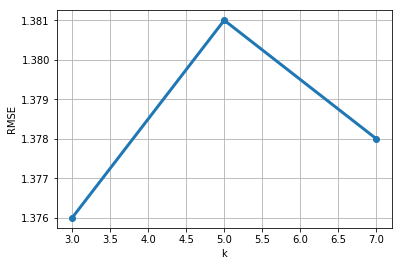

In [277]:
plt.plot([3,5,7], final_error, marker = 'o', linewidth = 3)
plt.grid()
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()